In [1]:
import os
import pickle
from functools import partial

import numpy as np
import pyabc
from fitmulticell import model as morpheus_model
from fitmulticell.sumstat import SummaryStatistics
from matplotlib import pyplot as plt
from tarp import get_tarp_coverage
from tqdm import tqdm

from summary_stats import reduced_coordinates_to_sumstat, reduce_to_coordinates, compute_mean_summary_stats
from plotting_routines import plot_compare_summary_stats, plot_trajectory

# get the job array id and number of processors
job_array_id = int(os.environ.get('SLURM_ARRAY_TASK_ID', 0))
n_procs = int(os.environ.get('SLURM_CPUS_PER_TASK', 1))
print(job_array_id)
on_cluster = False

0


In [2]:
if on_cluster:
    gp = '/home/jarruda_hpc/CellMigration/synth_data_params_bayesflow'
else:
    gp = os.getcwd()

# defining the mapping of parameter inside the model xml file. the dictionary name is for 
# parameter name, and the value are the mapping values, to get the map value for parameter 
# check here: https://fitmulticell.readthedocs.io/en/latest/example/minimal.html#Inference-problem-definition

par_map = {
    'gradient_strength': './CellTypes/CellType/Constant[@symbol="gradient_strength"]',
    'move.strength': './CellTypes/CellType/Constant[@symbol="move.strength"]',
    'move.duration.mean': './CellTypes/CellType/Constant[@symbol="move.duration.mean"]',
    'cell_nodes_real': './Global/Constant[@symbol="cell_nodes_real"]',
}

model_path = gp + "/cell_movement_v24.xml"  # time step is 30sec, move.dir completely normalized, init move.dir rand in all directions
# defining the summary statistics function
max_sequence_length = 120
min_sequence_length = 0
only_longest_traj_per_cell = True  # mainly to keep the data batchable
sumstat = SummaryStatistics(sum_stat_calculator=partial(reduce_to_coordinates,
                                                        minimal_length=min_sequence_length,
                                                        maximal_length=max_sequence_length,
                                                        only_longest_traj_per_cell=only_longest_traj_per_cell))                    

if on_cluster:
    # define the model object
    model = morpheus_model.MorpheusModel(
        model_path, par_map=par_map, par_scale="log10",
        show_stdout=False, show_stderr=False,
        executable="ulimit -s unlimited; /home/jarruda_hpc/CellMigration/morpheus-2.3.7",
        clean_simulation=True,
        raise_on_error=False, sumstat=sumstat)

    # todo: remember also change tiff path in model.xml!
else:
    # define the model object
    model = morpheus_model.MorpheusModel(
        model_path, par_map=par_map, par_scale="log10",
        show_stdout=False, show_stderr=False,
        clean_simulation=True,
        raise_on_error=False, sumstat=sumstat)


# parameter values used to generate the synthetic data
obs_pars = {
    'gradient_strength': 100.,  # strength of the gradient of chemotaxis
    'move.strength': 10.,  # strength of directed motion
    'move.duration.mean': 0.1,  # mean of exponential distribution (1/seconds)
    'cell_nodes_real': 50.,  # volume of the cell 
}

obs_pars_log = {key: np.log10(val) for key, val in obs_pars.items()}
limits = {'gradient_strength': (1, 10000), #(10 ** 4, 10 ** 8),
          'move.strength': (1, 100),
          'move.duration.mean': (1e-4, 30), #(math.log10((10 ** -2) * 30), math.log10((10 ** 4))), # smallest time step in simulation 5
          'cell_nodes_real': (1, 300)}
limits_log = {key: (np.log10(val[0]), np.log10(val[1])) for key, val in limits.items()}


prior = pyabc.Distribution(**{key: pyabc.RV("uniform", loc=lb, scale=ub-lb)
                              for key, (lb, ub) in limits_log.items()})
param_names = list(obs_pars.keys())
log_param_names = [f'log_{p}' for p in param_names]
print(obs_pars)

{'gradient_strength': 100.0, 'move.strength': 10.0, 'move.duration.mean': 0.1, 'cell_nodes_real': 50.0}


In [3]:
import tensorflow as tf
import bayesflow as bf
from bayesflow.amortizers import AmortizedPosterior
from bayesflow.networks import InvertibleNetwork
from bayesflow.helper_networks import MultiConv1D
from bayesflow.simulation import GenerativeModel, Prior, Simulator
from bayesflow.trainers import Trainer
from bayesflow import default_settings as defaults
from tensorflow.keras.layers import Dense, GRU, LSTM, Bidirectional
from tensorflow.keras.models import Sequential


def prior_fun(batch_size: int) -> np.ndarray:
    samples = []
    for _ in range(batch_size):
        samples.append(list(prior.rvs().values()))
    return np.array(samples)


def generate_population_data(param_batch: np.ndarray, cells_in_population: int, max_length: int) -> np.ndarray:
    """
    Generate population data
    :param param_batch:  batch of parameters
    :param cells_in_population:  number of cells in a population (50)
    :param max_length:  maximum length of the sequence
    :return:
    """
    data_batch = []
    for params in param_batch:
        params_dict = {key: p for key, p in zip(obs_pars.keys(), params)}
        sim = model.sample(params_dict)
        data_batch.append(sim)  # generates a cell population in one experiment

    data_batch_transformed = np.ones((param_batch.shape[0], cells_in_population, max_length, 2)) * np.nan
    # each cell is of different length, each with x and y coordinates, make a tensor out of it
    n_cells_not_visible = 0
    for p_id, population_sim in enumerate(data_batch):
        if len(population_sim) == 0:
            # no cells were visible in the simulation
            n_cells_not_visible += 1
            continue
        for c_id, cell_sim in enumerate(population_sim):
            # pre-pad the data with zeros, but first write zeros as nans to compute the mean and std
            data_batch_transformed[p_id, c_id, -len(cell_sim['x']):, 0] = cell_sim['x']
            data_batch_transformed[p_id, c_id, -len(cell_sim['y']):, 1] = cell_sim['y']

    if n_cells_not_visible > 0:
        print(f'Simulation with no cells visible: {n_cells_not_visible}/{len(data_batch)}')
    return data_batch_transformed

/Users/jonas.arruda/miniconda/envs/CellMigration/lib/python3.10/site-packages/bayesflow/trainers.py:27: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [4]:
presimulate = False
presimulation_path = 'presimulations'
n_val_data = 100
cells_in_population = 50
n_params = len(obs_pars)
batch_size = 32
iterations_per_epoch = 100
# 1000 batches to be generated, 10 epochs until the batch is used again
epochs = 500

# check if gpu is available
print('gpu:', tf.config.list_physical_devices('GPU'))

bayesflow_prior = Prior(batch_prior_fun=prior_fun, param_names=param_names)
bayes_simulator = Simulator(batch_simulator_fun=partial(generate_population_data,
                                                        cells_in_population=cells_in_population,
                                                        max_length=max_sequence_length))
generative_model = GenerativeModel(prior=bayesflow_prior, simulator=bayes_simulator,
                                   skip_test=True,  # once is enough, simulation takes time
                                   name="Normalizing Flow Generative Model")

gpu: []


In [5]:
if presimulate:
    print('presimulating')
    from time import sleep
    sleep(job_array_id)
    
    # we create on batch per job and save it in a folder
    epoch_id = job_array_id // iterations_per_epoch
    generative_model.presimulate_and_save(batch_size=batch_size, 
                                          folder_path=presimulation_path+f'/epoch_{epoch_id}',
                                          iterations_per_epoch=1,
                                          epochs=1,
                                          extend_from=job_array_id,
                                          disable_user_input=True)
    print('Done!')

In [6]:
def custom_loader(file_path):
    """Uses pickle to load, but each path is folder with multiple files, each one batch"""
    # load all files in folder
    loaded_presimulations = []
    for file in os.listdir(file_path):
        with open(os.path.join(file_path, file), 'rb') as f:
            test = pickle.load(f)[0]
            assert isinstance(test, dict)
            loaded_presimulations.append(test)
    # shuffle list, so iterations are random, only batches stay the same
    np.random.shuffle(loaded_presimulations)
    return loaded_presimulations

In [7]:
if os.path.exists(os.path.join(gp, 'validation_data.pickle')):
    with open(os.path.join(gp, 'validation_data.pickle'), 'rb') as f:
        valid_data = pickle.load(f)
else:
    print('Generating validation data')
    valid_data = generative_model(n_val_data)
    # save the data
    with open(os.path.join(gp, 'validation_data.pickle'), 'wb') as f:
        pickle.dump(valid_data, f)

x_mean = np.nanmean(valid_data['sim_data'], axis=(0, 1, 2))
x_std = np.nanstd(valid_data['sim_data'], axis=(0, 1, 2))
p_mean = np.mean(valid_data['prior_draws'], axis=0)
p_std = np.std(valid_data['prior_draws'], axis=0)
print('Mean and std of data:', x_mean, x_std)
print('Mean and std of parameters:', p_mean, p_std)


# compute the mean of the summary statistics
summary_stats_list_ = [reduced_coordinates_to_sumstat(t) for t in valid_data['sim_data']]
(_, ad_averg, _, MSD_averg, _, TA_averg, _, VEL_averg, _, WT_averg) = compute_mean_summary_stats(summary_stats_list_, remove_nan=False)
direct_conditions_ = np.stack([ad_averg, MSD_averg, TA_averg, VEL_averg, WT_averg]).T
# replace inf with -1
direct_conditions_[np.isinf(direct_conditions_)] = np.nan
        
summary_valid_max = np.nanmax(direct_conditions_, axis=0)
summary_valid_min = np.nanmin(direct_conditions_, axis=0)

Mean and std of data: [ 584.8564567  1218.30836285] [48.56665046 59.88427128]
Mean and std of parameters: [ 1.95494199  0.99490352 -1.43414929  1.15144457] [1.13024234 0.57772408 1.38909074 0.76196229]


In [8]:
def configurator(forward_dict: dict, manual_summary: bool = False) -> dict:
    out_dict = {}

    # Extract data
    x = forward_dict["sim_data"]
    
    # compute manual summary statistics
    if manual_summary:
        summary_stats_list = [reduced_coordinates_to_sumstat(t) for t in x]
        # compute the mean of the summary statistics
        (_, ad_averg, _, MSD_averg, _, 
         TA_averg, _, VEL_averg, _, WT_averg) = compute_mean_summary_stats(summary_stats_list, remove_nan=False)
        direct_conditions = np.stack([ad_averg, MSD_averg, TA_averg, VEL_averg, WT_averg]).T   
        # normalize statistics
        direct_conditions = (direct_conditions - summary_valid_min) / (summary_valid_max - summary_valid_min)
        # replace nan or inf with -1
        direct_conditions[np.isinf(direct_conditions)] = -1
        direct_conditions[np.isnan(direct_conditions)] = -1
        out_dict['direct_conditions'] = direct_conditions.astype(np.float32)
    
    # Normalize data
    x = (x - x_mean) / x_std
    
    # Check for NaN values in the first entry of the last axis
    # If nan_mask is False (no NaNs), set to 1; otherwise, set to 0
    nan_mask = np.isnan(x[..., 0])
    new_dim = np.where(nan_mask, 0, 1)
    new_dim_expanded = np.expand_dims(new_dim, axis=-1)
    x = np.concatenate((x, new_dim_expanded), axis=-1)

    # Normalize data
    x[np.isnan(x)] = 0  # replace nan with 0, pre-padding (since we have nans in the data at the end)
    out_dict['summary_conditions'] = x.astype(np.float32)

    # Extract params
    if 'parameters' in forward_dict.keys():
        forward_dict["prior_draws"] = forward_dict["parameters"]
    if 'prior_draws' in forward_dict.keys():
        params = forward_dict["prior_draws"]
        params = (params - p_mean) / p_std
        out_dict['parameters'] = params.astype(np.float32)
    return out_dict

In [9]:
# define the network    
class GroupSummaryNetwork(tf.keras.Model):
    """Network to summarize the data of groups of cells.  Each group is passed through a series of convolutional layers
    followed by an LSTM layer. The output of the LSTM layer is then pooled across the groups and dense layer applied
    to obtain a summary of fixed dimensionality. The network is invariant to the order of the groups.
    """
    def __init__(
            self,
            summary_dim,
            num_conv_layers=2,
            rnn_units=128,
            bidirectional=True,
            conv_settings=None,
            use_attention=False,
            return_attention_weights=False,
            use_GRU=True,
            **kwargs
    ):
        super().__init__(**kwargs)

        if conv_settings is None:
            conv_settings = defaults.DEFAULT_SETTING_MULTI_CONV
        self.conv_settings = conv_settings

        conv = Sequential([MultiConv1D(conv_settings) for _ in range(num_conv_layers)])
        self.num_conv_layers = num_conv_layers
        self.group_conv = tf.keras.layers.TimeDistributed(conv)
        self.use_attention = use_attention
        self.return_attention_weights = return_attention_weights
        self.pooling = tf.keras.layers.GlobalAveragePooling1D()
        self.rnn_units = rnn_units
        self.use_GRU = use_GRU
        self.bidirectional = bidirectional
        
        if self.use_attention:
            self.attention = tf.keras.layers.MultiHeadAttention(num_heads=4, key_dim=rnn_units)
        
        if use_GRU:
            rnn = Bidirectional(GRU(rnn_units, return_sequences=use_attention)) if bidirectional else GRU(rnn_units, return_sequences=use_attention)
        else:
            rnn = Bidirectional(LSTM(rnn_units, return_sequences=use_attention)) if bidirectional else LSTM(rnn_units, return_sequences=use_attention)   
        self.group_rnn = tf.keras.layers.TimeDistributed(rnn)
            
        self.out_layer = Dense(summary_dim, activation="linear")
        self.summary_dim = summary_dim

    def call(self, x, **kwargs):
        """Performs a forward pass through the network by first passing `x` through the same rnn network for
        each household and then pooling the outputs across households.

        Parameters
        ----------
        x : tf.Tensor
            Input of shape (batch_size, n_groups, n_time_steps, n_features)

        Returns
        -------
        out : tf.Tensor
            Output of shape (batch_size, summary_dim)
        """
        # Apply the RNN to each group
        out = self.group_conv(x, **kwargs) 
        out = self.group_rnn(out, **kwargs)  # (batch_size, n_groups, lstm_units)
        # if attention is used, return full sequence (batch_size, n_groups, n_time_steps, lstm_units)
        # bidirectional LSTM returns 2*lstm_units

        if self.use_attention:
            # learn a query vector to attend over the time points
            query = tf.reduce_mean(out, axis=1)
            # Reshape query to match the required shape for attention
            query = tf.expand_dims(query, axis=1)  # (batch_size, 1, n_time_steps, lstm_units)
            if not self.return_attention_weights:
                out = self.attention(query, out, **kwargs)  # (batch_size, 1, n_time_steps, lstm_units)
            else:
                out, attention_weights = self.attention(query, out, return_attention_scores=True, **kwargs)
                attention_weights = tf.squeeze(attention_weights, axis=2)
            out = tf.squeeze(out, axis=1)  # Remove the extra dimension (batch_size, n_time_steps, lstm_units)
            out = self.pooling(out, **kwargs)  # (batch_size, 1, lstm_units)
        else:
            # pooling over groups, this totally invariants to the order of the groups
            out = self.pooling(out, **kwargs)  # (batch_size, lstm_units)
        # apply dense layer
        out = self.out_layer(out, **kwargs)  # (batch_size, summary_dim)
        
        if self.use_attention and self.return_attention_weights:
            return out, attention_weights
        return out

    def get_config(self):
        """Return the config for serialization."""
        config = super().get_config()
        config.update({
            'summary_dim': self.summary_dim,
            'num_conv_layers': self.num_conv_layers,
            'rnn_units': self.rnn_units,
            'bidirectional': self.bidirectional,
            'conv_settings': self.conv_settings,
            'use_attention': self.use_attention,
            'return_attention_weights': self.return_attention_weights,
            'use_GRU': self.use_GRU,
        })
        return config

    @classmethod
    def from_config(cls, config):
        """Recreate the model from the config."""
        return cls(**config)

In [10]:
job_array_id = 5

num_coupling_layers = 6
num_dense = 3
use_attention = True
use_bidirectional = True
summary_loss = 'MMD'
use_manual_summary = False
if job_array_id == 0:
    checkpoint_path = 'amortizer-cell-migration-attention-6'
    map_idx_sim = 52
elif job_array_id == 1:
    checkpoint_path = 'amortizer-cell-migration-attention-6-manual'
    use_manual_summary = True
    map_idx_sim = 6
elif job_array_id == 2:
    checkpoint_path = 'amortizer-cell-migration-attention-7'
    num_coupling_layers = 7
    map_idx_sim = 52
elif job_array_id == 3:
    checkpoint_path = 'amortizer-cell-migration-attention-7-manual'
    num_coupling_layers = 7
    use_manual_summary = True
    map_idx_sim = 28
elif job_array_id == 4:
    checkpoint_path = 'amortizer-cell-migration-attention-8'
    num_coupling_layers = 8
    map_idx_sim = 69
elif job_array_id == 5:
    checkpoint_path = 'amortizer-cell-migration-attention-8-manual'
    num_coupling_layers = 8
    use_manual_summary = True
    map_idx_sim = 86
else:
    raise ValueError('Checkpoint path not found')
print(checkpoint_path)
os.makedirs(f"../results/{checkpoint_path}", exist_ok=True)
print(checkpoint_path)

summary_net = GroupSummaryNetwork(summary_dim=n_params * 2,
                                  rnn_units=32,
                                  use_attention=use_attention,
                                  bidirectional=use_bidirectional)
inference_net = InvertibleNetwork(num_params=n_params,
                                  num_coupling_layers=num_coupling_layers,
                                  coupling_design='spline',
                                  coupling_settings={
                                      "num_dense": num_dense,
                                      "dense_args": dict(
                                          activation='relu',
                                          kernel_regularizer=tf.keras.regularizers.l2(1e-4),
                                      ),
                                      "dropout_prob": 0.2,
                                      "bins": 16,
                                  })

amortizer = AmortizedPosterior(inference_net=inference_net, summary_net=summary_net,
                               summary_loss_fun=summary_loss)

amortizer-cell-migration-attention-8-manual
amortizer-cell-migration-attention-8-manual


In [11]:
# build the trainer with networks and generative model
max_to_keep = 17
trainer = Trainer(amortizer=amortizer,
                  configurator=partial(configurator, 
                                       manual_summary=use_manual_summary),
                  generative_model=generative_model,
                  checkpoint_path=checkpoint_path,
                  skip_checks=True,  # once is enough, simulation takes time
                  max_to_keep=max_to_keep)

# check if file exist
if os.path.exists(checkpoint_path):
    trainer.load_pretrained_network()
    history = trainer.loss_history.get_plottable()
else:
    trainer._setup_optimizer(optimizer=None,
                         epochs=epochs,
                         iterations_per_epoch=iterations_per_epoch)
    
    history = trainer.train_from_presimulation(presimulation_path=presimulation_path,
                                               optimizer=trainer.optimizer,
                                               max_epochs=epochs,
                                               early_stopping=True,
                                               early_stopping_args={'patience': max_to_keep-2},
                                               custom_loader=custom_loader,
                                               validation_sims=valid_data)
    print('Training done!')

INFO:root:Loaded loss history from amortizer-cell-migration-attention-8-manual/history_486.pkl.
INFO:root:Networks loaded from amortizer-cell-migration-attention-8-manual/ckpt-486


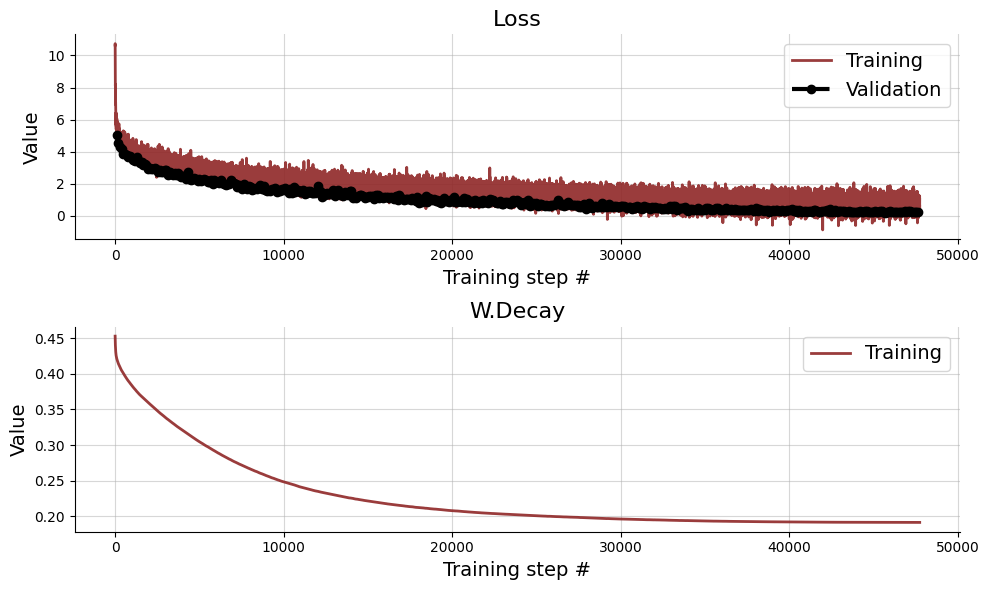

In [12]:
bf.diagnostics.plot_losses(history['train_losses'], history['val_losses'], fig_size=(10, 6));

In [13]:
# Check if training converged
if np.isnan(history['val_losses'].iloc[-1]).any():
    print('Training failed with NaN loss at the end')
    if np.isnan(history['val_losses'].iloc[-max_to_keep:]).all():
        print('Training failed with NaN loss for all latest checkpoints')

# Find the checkpoint with the lowest validation loss out of the last max_to_keep
recent_losses = history['val_losses'].iloc[-max_to_keep:]
best_valid_epoch = recent_losses['Loss'].idxmin() + 1  # checkpoints are 1-based indexed
new_checkpoint = trainer.manager.latest_checkpoint.rsplit('-', 1)[0] + f'-{best_valid_epoch}'    
trainer.checkpoint.restore(new_checkpoint)
print(f"Networks loaded from {new_checkpoint} with {recent_losses['Loss'][best_valid_epoch-1]} validation loss")

Networks loaded from amortizer-cell-migration-attention-8-manual/ckpt-476 with 0.21413370966911316 validation loss


# Diagnostic plots

In [14]:
valid_data_config = trainer.configurator(valid_data)

In [15]:
posterior_samples = amortizer.sample(valid_data_config, n_samples=100)
posterior_samples = posterior_samples * p_std + p_mean
prior_draws = valid_data_config["parameters"] * p_std + p_mean

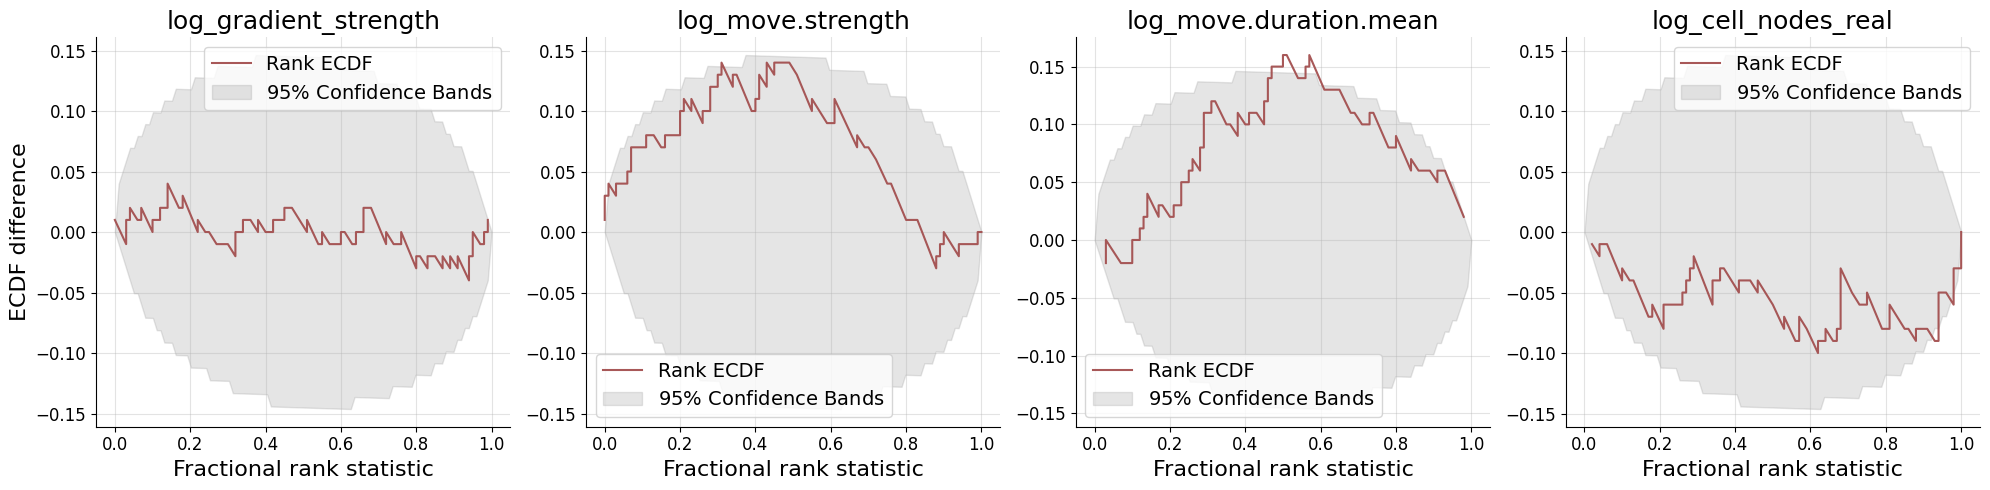

In [16]:
bf.diagnostics.plot_sbc_ecdf(posterior_samples, prior_draws, difference=True, param_names=log_param_names)
plt.savefig(f'{checkpoint_path}/sbc_ecdf.png')

In [17]:
posterior_samples = amortizer.sample(valid_data_config, n_samples=1000)
posterior_samples = posterior_samples * p_std + p_mean

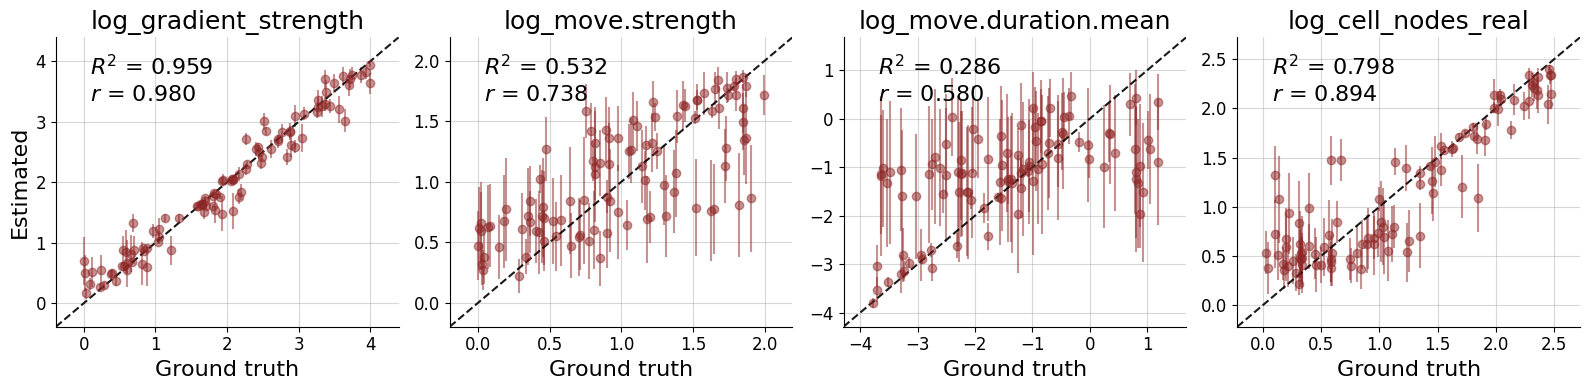

In [18]:
bf.diagnostics.plot_recovery(posterior_samples, prior_draws, param_names=log_param_names)
plt.savefig(f'{checkpoint_path}/recovery.png')

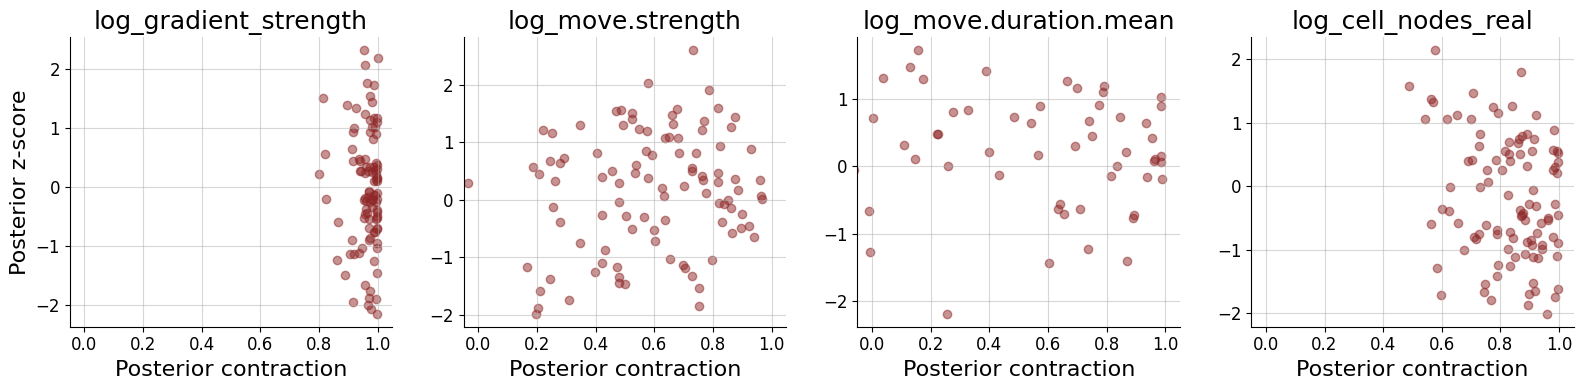

In [19]:
bf.diagnostics.plot_z_score_contraction(posterior_samples, prior_draws, param_names=log_param_names);

In [20]:
posterior_samples_reshaped = posterior_samples.reshape(posterior_samples.shape[1],
                                                       posterior_samples.shape[0], posterior_samples.shape[2])

In [21]:
ecp_bootstrap, alpha = get_tarp_coverage(posterior_samples_reshaped, prior_draws, references='random',
                                         metric='euclidean', norm=True, bootstrap=True)

100%|██████████| 100/100 [00:00<00:00, 277.64it/s]


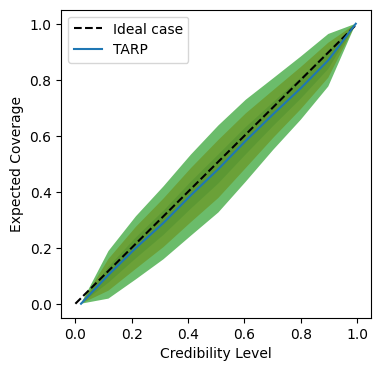

In [22]:
k_sigma = [1, 2, 3]

fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.plot([0, 1], [0, 1], ls='--', color='k', label="Ideal case")
ax.plot(alpha, ecp_bootstrap.mean(axis=0), label='TARP')
for k in k_sigma:
    ax.fill_between(alpha, 
                    ecp_bootstrap.mean(axis=0) - k * ecp_bootstrap.std(axis=0), 
                    ecp_bootstrap.mean(axis=0) + k * ecp_bootstrap.std(axis=0), 
                    alpha = 0.7)
ax.legend()
ax.set_ylabel("Expected Coverage")
ax.set_xlabel("Credibility Level")
plt.show()

# Test on synthetic data

In [23]:
# simulate test data
test_params = np.array(list(obs_pars_log.values()))
if not os.path.exists(os.path.join(gp, 'test_sim.npy')):
    test_sim_full = bayes_simulator(test_params[np.newaxis])
    test_sim = test_sim_full['sim_data']
    np.save(os.path.join(gp, 'test_sim.npy'), test_sim)
else:
    test_sim = np.load(os.path.join(gp, 'test_sim.npy'))
    test_sim_full = {'sim_data': test_sim}
test_sim.shape

(1, 50, 120, 2)

In [24]:
test_posterior_samples = amortizer.sample(trainer.configurator(test_sim_full), n_samples=100)
test_posterior_samples = test_posterior_samples * p_std + p_mean

# compute the log posterior of the test data
input_dict = {
    'sim_data': np.repeat(test_sim, repeats=100, axis=0),
    'parameters': test_posterior_samples
}
log_prob = amortizer.log_posterior(trainer.configurator(input_dict))
    
# get the MAP
map_idx = np.argmax(log_prob)

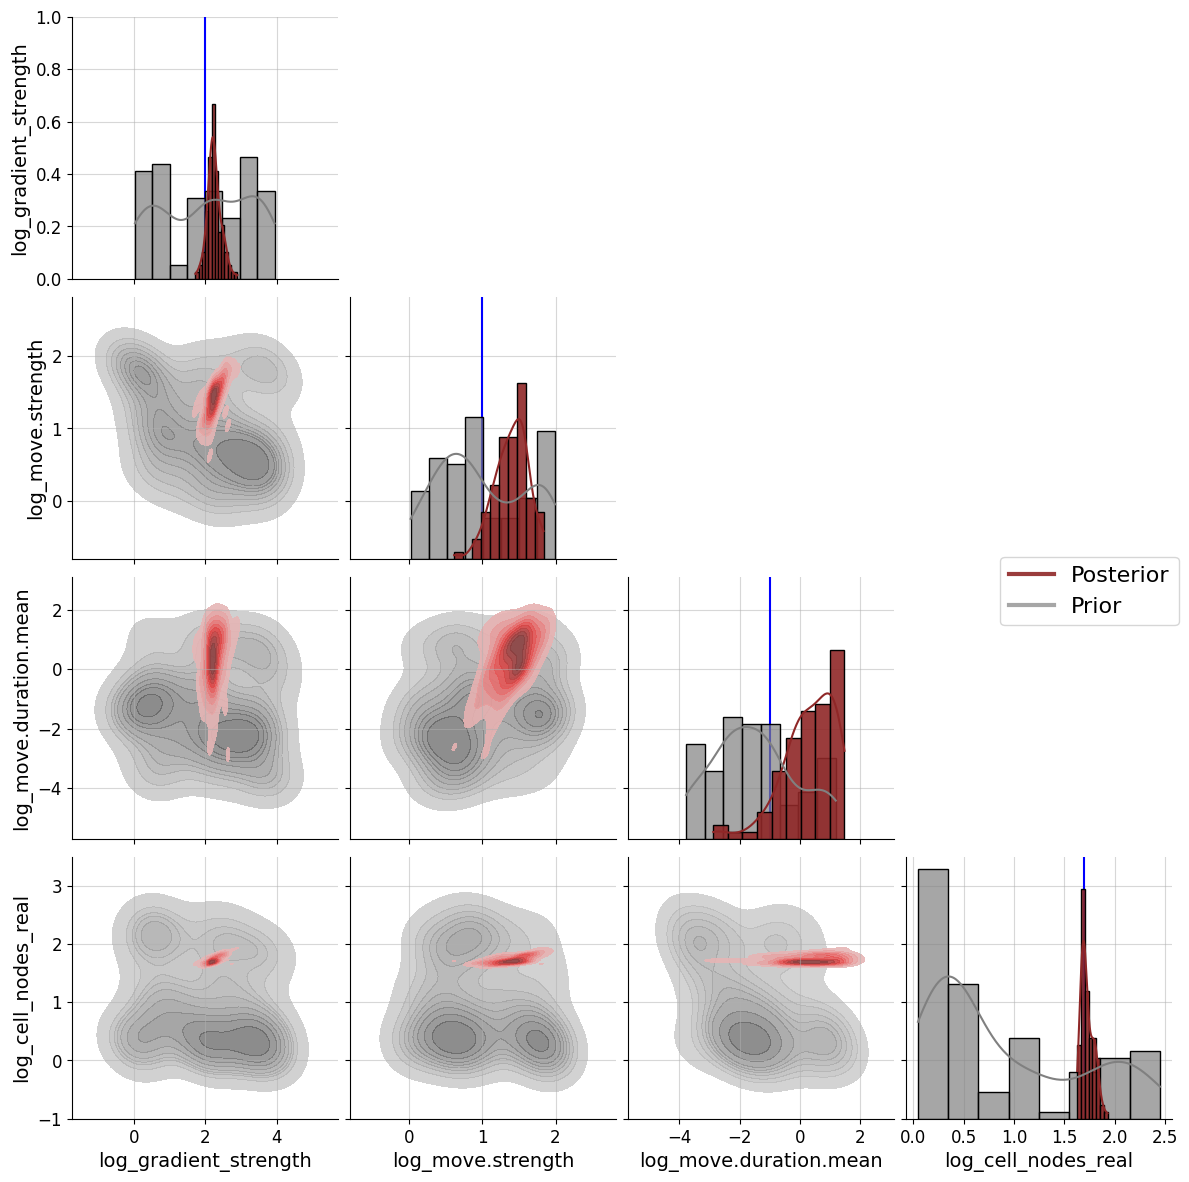

In [25]:
fig = bf.diagnostics.plot_posterior_2d(posterior_draws=test_posterior_samples,
                                       prior_draws=prior_draws[:test_posterior_samples.shape[0]],
                                       param_names=log_param_names)
# from figure get axis
ax = fig.get_axes()
for i, a in enumerate(ax):
    # plot only on the diagonal
    if i == i // len(log_param_names) * (len(log_param_names)+1):
        a.axvline(test_params[i // len(log_param_names)], color='b', label='True parameter')
plt.savefig(f'{checkpoint_path}/posterior_vs_prior.png')
plt.show()

In [26]:
# get posterior samples and simulate
if not os.path.exists(checkpoint_path+'/posterior_sim.npy'):
    # simulate the data
    posterior_sim = bayes_simulator(test_posterior_samples)['sim_data']
    np.save(checkpoint_path+'/posterior_sim.npy', posterior_sim)
    
    print('map_sim', map_idx, log_prob[map_idx], test_posterior_samples[map_idx])
    map_idx_sim = map_idx
else:
    posterior_sim = np.load(checkpoint_path+'/posterior_sim.npy')

# reorder the posterior samples
posterior_sim = np.delete(posterior_sim, map_idx_sim, axis=0)
posterior_sim = np.insert(posterior_sim, 0, posterior_sim[map_idx_sim][np.newaxis], axis=0)

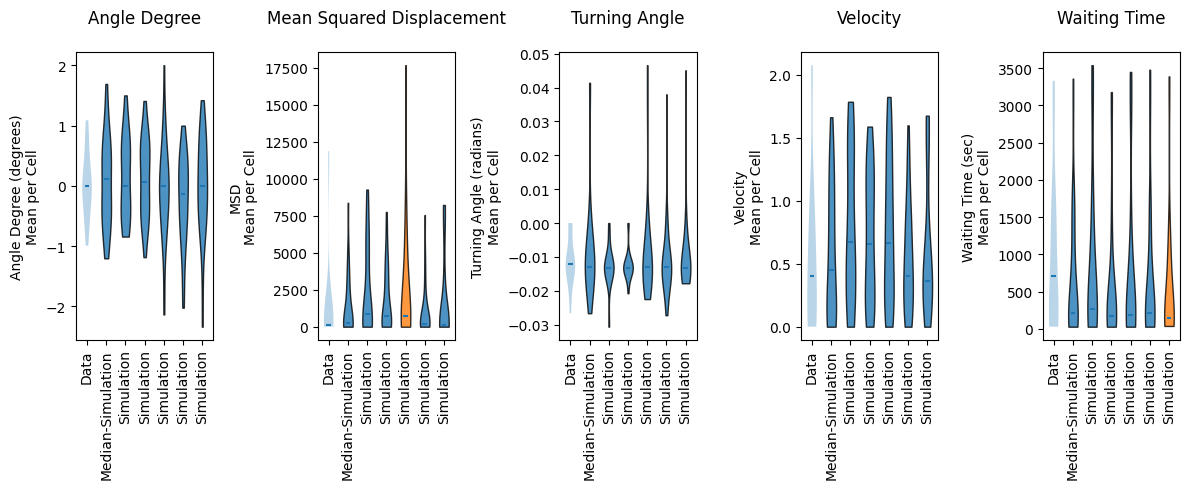

Wasserstein distance: 1210.235229609607


1210.235229609607

In [27]:
# plot the summary statistics
plot_compare_summary_stats(test_sim, posterior_sim, path=f'{checkpoint_path}/Summary Stats.png')

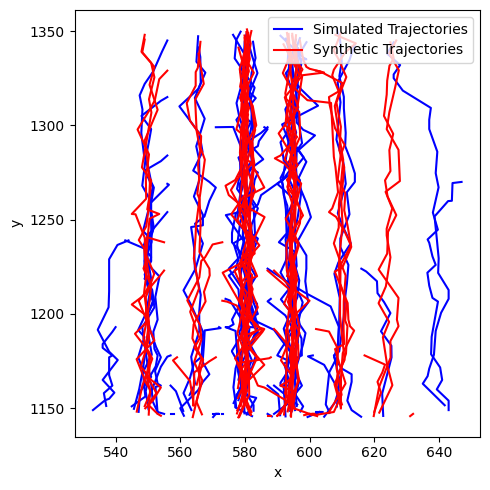

In [28]:
# plot the trajectories
plot_trajectory(test_sim[0], posterior_sim[0], path=f'{checkpoint_path}/Simulations.png')

  0%|          | 0/500 [00:00<?, ?it/s]

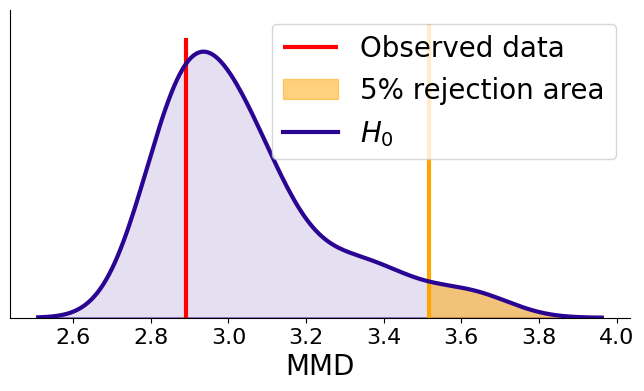

In [29]:
if summary_loss is not None:
    test_data_config = trainer.configurator(test_sim_full)
    
    MMD_sampling_distribution, MMD_observed = trainer.mmd_hypothesis_test(
        observed_data=test_data_config, 
        reference_data=valid_data_config,  # if not provided, will use the generative model
        num_null_samples=500,
        bootstrap=True  # if True, use the reference data as null samples
    )
    fig = bf.diagnostics.plot_mmd_hypothesis_test(MMD_sampling_distribution, MMD_observed)
    fig.savefig(f'{checkpoint_path}/Synthetic MMD.png', bbox_inches='tight')
    plt.show()

# Real Data

In [30]:
from load_data import load_real_data

wasserstein_distance_dict = {0: np.nan, 1: np.nan}
samples_dict = {0: np.nan, 1: np.nan}

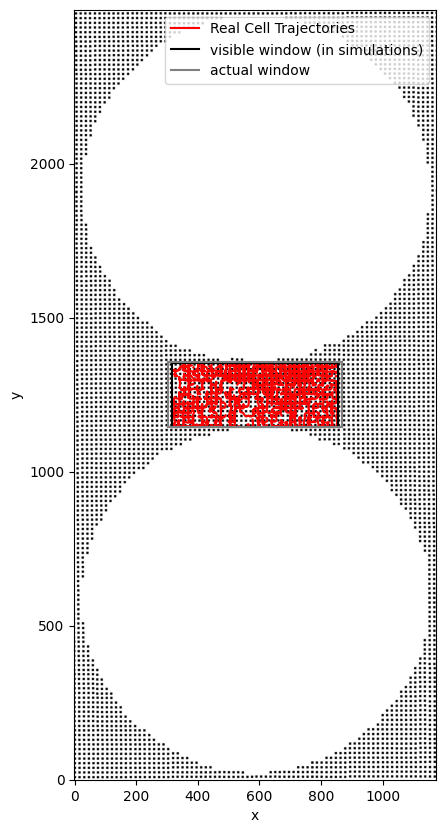

(400, 120, 2)


In [39]:
real_data_id = [0, 1][1]
real_data, real_data_full = load_real_data(data_id=real_data_id, 
                                           max_sequence_length=max_sequence_length, 
                                           cells_in_population=cells_in_population,
                                           plot_data=True)
print(real_data.shape)

Zelldichte macht was aus

Wo wollen Zellen hin? welche parameter beeinflussen das ganze? Zelldichte?

1,5mm

1 (nicht so gut, extrema)
739.79x279.74  microns
20231x768 pixel


2 (wesentlich mehr der Wahrheit)
882.94x287.03 microns
2424x788 pixel


In [40]:
# batch the real data
batches = [real_data[i * cells_in_population:(i + 1) * cells_in_population] 
           for i in range(len(real_data) // cells_in_population)]
real_posterior_samples_full = []
map_idx_full = []
n_samples = 100

for b in tqdm(batches):
    real_posterior_samples = amortizer.sample(trainer.configurator({'sim_data': b[np.newaxis]}), 
                                          n_samples=n_samples)
    real_posterior_samples = real_posterior_samples * p_std + p_mean
    real_posterior_samples_full.append(real_posterior_samples)
    
    # compute the log posterior of the test data
    input_dict = {
        'sim_data': np.repeat(b[np.newaxis], repeats=n_samples, axis=0),
        'parameters': real_posterior_samples
    }
    log_prob = amortizer.log_posterior(trainer.configurator(input_dict))
    # get the MAP
    map_idx = np.argmax(log_prob)
    map_idx_full.append(map_idx)
     
real_posterior_samples = np.concatenate(real_posterior_samples_full)
map_idxs = np.array(map_idx_full)
samples_dict[real_data_id] = real_posterior_samples

100%|██████████| 8/8 [00:33<00:00,  4.18s/it]


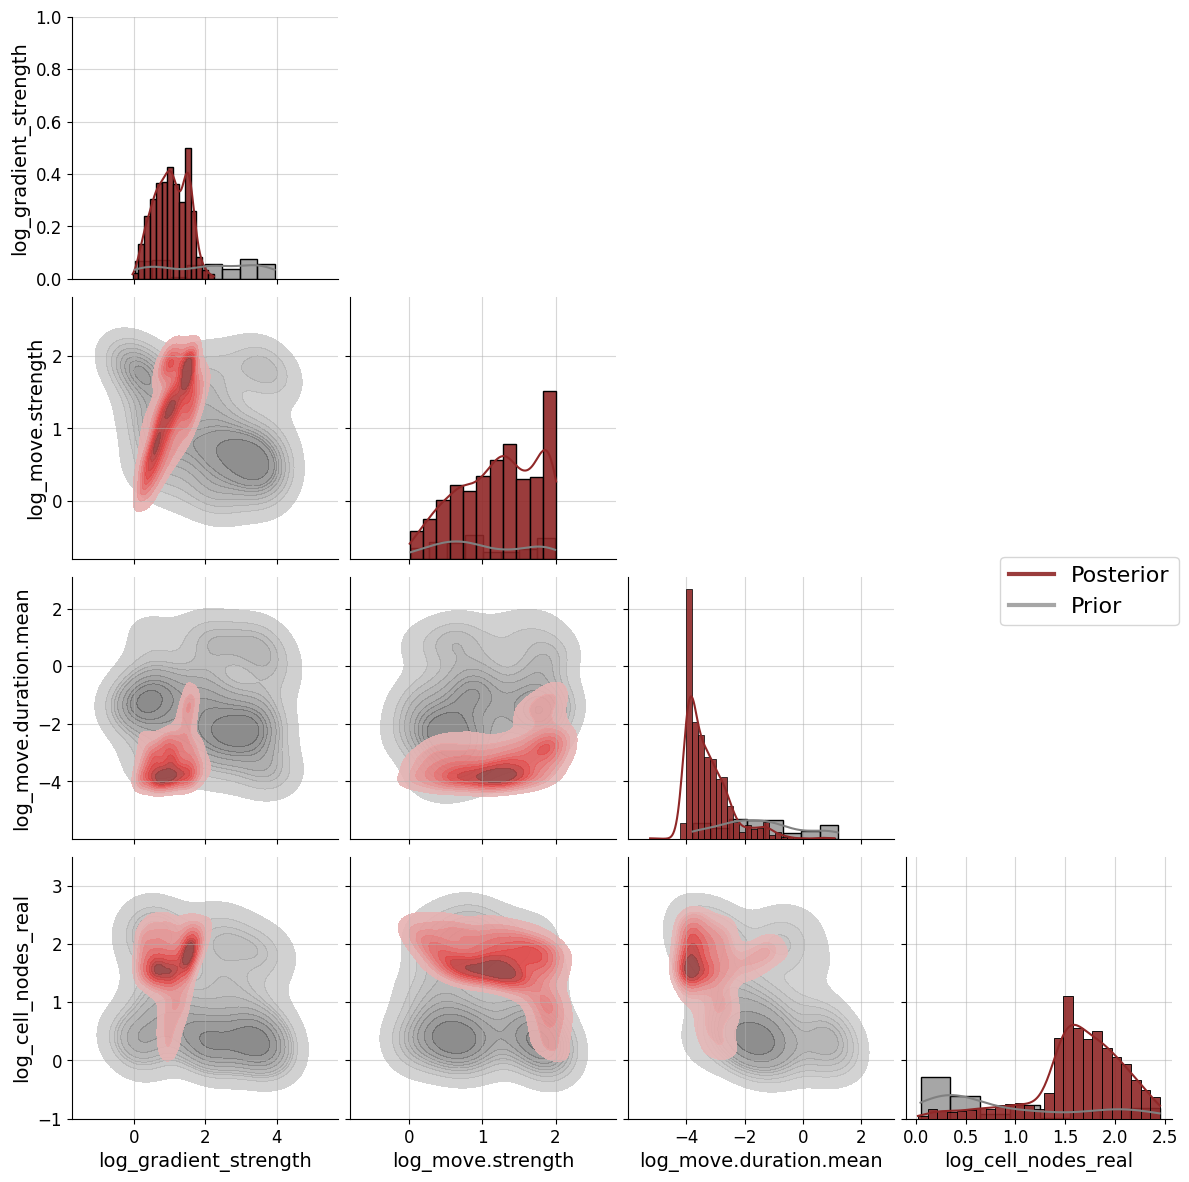

In [41]:
fig = bf.diagnostics.plot_posterior_2d(posterior_draws=real_posterior_samples,
                                       prior_draws=prior_draws[:real_posterior_samples.shape[0]],
                                       param_names=log_param_names)
plt.savefig(f'{checkpoint_path}/Real_{real_data_id} posterior_vs_prior {len(batches)}.png')
plt.show()

In [42]:
# get posterior samples and simulate
map_sims_real = []
for i, map_idx in tqdm(enumerate(map_idxs), total=len(map_idxs)):
    if not os.path.exists(checkpoint_path+f'/posterior_sim_real_{real_data_id}_{i}.npy'):
        # simulate the data
        map_sim_real = bayes_simulator(real_posterior_samples[map_idx + i*n_samples][np.newaxis])['sim_data'][0]
        np.save(checkpoint_path+f'/posterior_sim_real_{real_data_id}_{i}.npy', map_sim_real)
    else:
        # load the data
        map_sim_real = np.load(checkpoint_path+f'/posterior_sim_real_{real_data_id}_{i}.npy')
    map_sims_real.append(map_sim_real)
map_sim_real = np.concatenate(map_sims_real)

100%|██████████| 8/8 [00:00<00:00, 1722.33it/s]


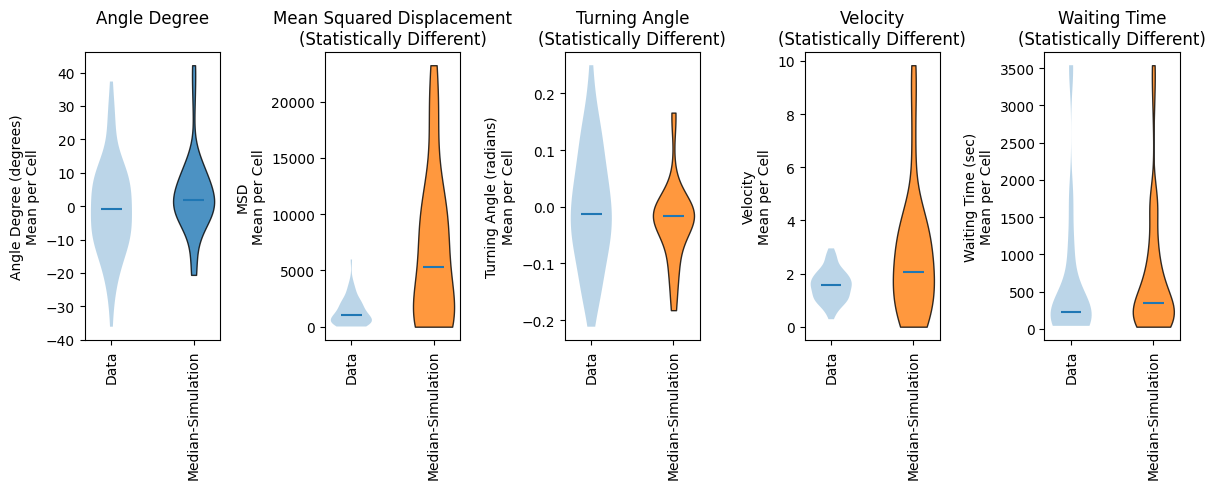

Wasserstein distance: 5499.221929557172
Wasserstein distance both datasets: 7435.804979075707


In [43]:
wasserstein_distance_dict[real_data_id] = plot_compare_summary_stats([real_data], [map_sim_real], 
                                                                     path=f'{checkpoint_path}/Real_{real_data_id} vs Simulations {len(batches)}.png')
print(f"Wasserstein distance both datasets: {np.sum(list(wasserstein_distance_dict.values()))}")

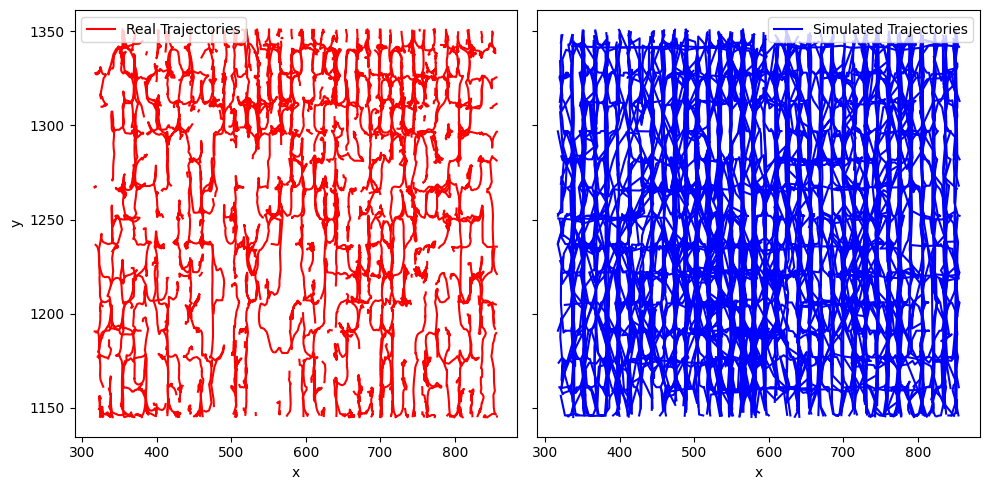

In [44]:
plot_trajectory(real_data, map_sim_real,
                path=f'{checkpoint_path}/Real_{real_data_id} Simulations {len(batches)}.png', 
                label_true='Real Trajectories', two_plots=True, show_image=False)

  0%|          | 0/500 [00:00<?, ?it/s]

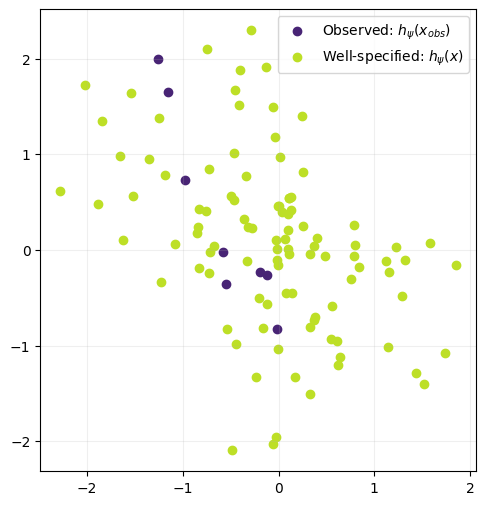

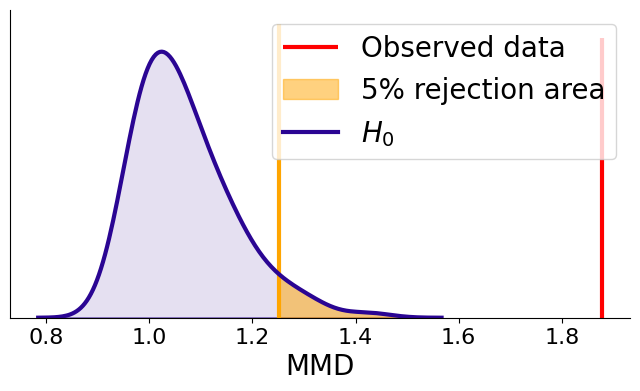

In [45]:
if summary_loss is not None:
    from matplotlib.cm import viridis
    real_data_config = trainer.configurator({'sim_data': batches})
    summary_statistics = trainer.amortizer.summary_net(valid_data_config['summary_conditions'])
    summary_statistics_obs = trainer.amortizer.summary_net(real_data_config['summary_conditions'])
    fig, ax = plt.subplots(1, 1, figsize=(12, 6))
    colors = viridis(np.linspace(0.1, 0.9, 2))
    ax.scatter(
        summary_statistics_obs[:, 0], summary_statistics_obs[:, 1], color=colors[0], label=r"Observed: $h_{\psi}(x_{obs})$"
    )
    ax.scatter(summary_statistics[:, 0], summary_statistics[:, 1], color=colors[1], label=r"Well-specified: $h_{\psi}(x)$")
    ax.legend()
    ax.grid(alpha=0.2)
    plt.gca().set_aspect("equal")
    
    fig.savefig(f'{checkpoint_path}/Real_{real_data_id} Summary Latent Space.png',
                bbox_inches='tight')
    
    MMD_sampling_distribution, MMD_observed = trainer.mmd_hypothesis_test(
        observed_data=real_data_config, 
        reference_data=valid_data_config,  # if not provided, will use the generative model
        num_null_samples=500,
        bootstrap=True  # if True, use the reference data as null samples
    )
    fig = bf.diagnostics.plot_mmd_hypothesis_test(MMD_sampling_distribution, MMD_observed)
    fig.savefig(f'{checkpoint_path}/Real_{real_data_id} MMD.png',
                bbox_inches='tight')
    plt.show()

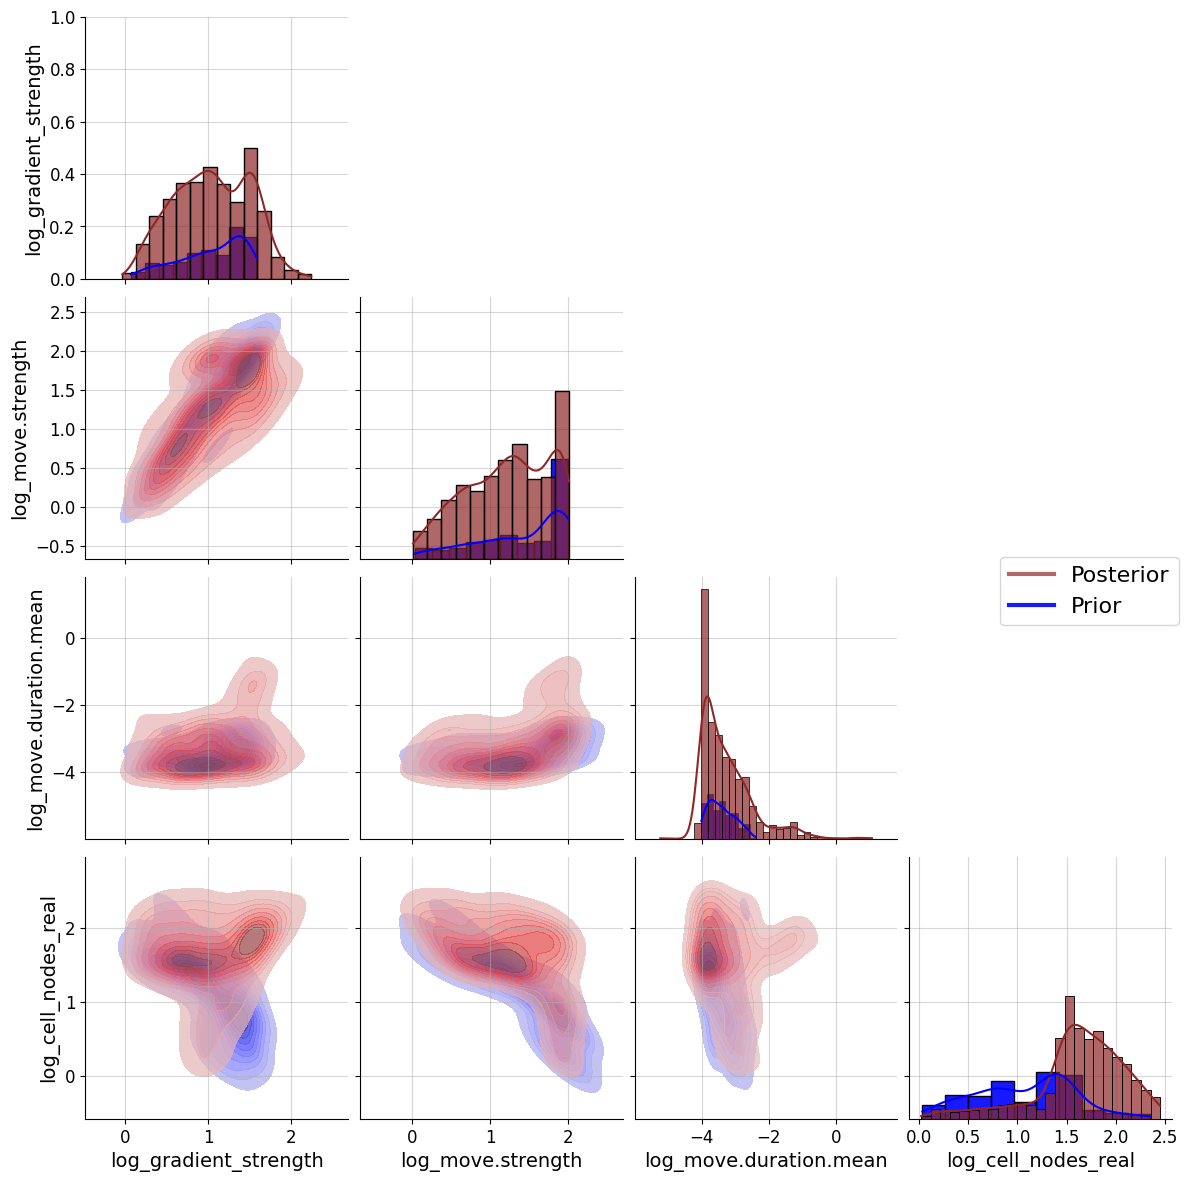

In [46]:
if not np.isnan(samples_dict[0]).all() and not np.isnan(samples_dict[1]).all():
    fig = bf.diagnostics.plot_posterior_2d(posterior_draws=samples_dict[0],
                                           prior_draws=samples_dict[1],
                                           post_alpha=0.7,
                                           #post_color='red',
                                           prior_alpha=0.9, # other posterior samples
                                           prior_color='blue',
                                           param_names=log_param_names)
    plt.savefig(f'{checkpoint_path}/Real posterior_vs_posterior.png')
    plt.show()